## 0. Import Libraries

In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.cache_utils import DynamicCache
from models import NaiveWrapper, SDWrapper, SSM_Sequoia, SSM_Eagle
from models.utils import TreeDynamicCache, invert_mask
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy


/home/nctu/envs/eagle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initialize model

In [2]:
def load_model(
    llm_path: str,
    ssm_path: str,
    mode: str,
    sd_method: str,
    dtype: torch.dtype = torch.float16,
    device: str = "auto",
    ):
    # load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(llm_path, use_fast=False)
    
    # load LLM
    llm = AutoModelForCausalLM.from_pretrained(
        llm_path, 
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        device_map=device
    )

    model = SDWrapper(method=sd_method)
        
    # load SSM
    draft_config = deepcopy(llm.config)
    draft_config.num_hidden_layers = 2#3#2#1
    # ssm = SSM_Sequoia.from_pretrained(
    ssm = SSM_Eagle.from_pretrained(
        ssm_path, 
        config=draft_config,
        torch_dtype=dtype,
    ).to(llm.model.layers[-1].self_attn.q_proj.weight.device)
    model.set_ssm(ssm)
    
    # set model
    model.set_tokenizer(tokenizer)
    model.set_llm(llm)
    model.eval()
    
    return model, tokenizer

In [3]:
device = "auto"
dtype = torch.float16
llm_path = "meta-llama/Llama-2-7b-chat-hf"
# ssm_path = "/home/nctu/checkpoints/eagle/l1-kl_1.0-0.1/model_20"
ssm_path = "/home/nctu/checkpoints/eagle/0919/d2/l1-kl_1.0-0.1/model_20"
# ssm_path = "/home/nctu/checkpoints/eagle/0921/d2/preload/l1-kl_1.0-0.1/model_20"


# ssm_path = "/home/nctu/checkpoints/eagle/0911/T0.8-l1-kl_1.0-0.1/model_20/"
# ssm_path = "/home/nctu/checkpoints/eagle/0910/T2.5-l1-kl_1.0-0.1/model_20/"
# ssm_path = "/home/nctu/checkpoints/eagle/0908/skl-tv_1.0-1.0/model_20/"
# sd_method = "sequoia"
# ssm_path = "/home/nctu/checkpoints/eagle/official/EAGLE-llama2-chat-7B/"
# ssm_path = "/home/nctu/checkpoints/eagle/ft_l1-tv_1.0-1.0/model_20"

sd_method = "eagle"
model, tokenizer = load_model(llm_path, ssm_path, "sd", sd_method, dtype, device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


In [4]:
# Sampling configurations

temperature = 0.6#1.5
top_p = None#0.9
top_k = None#0
do_sample = None#True

logits_warper = (
    model._get_logits_warper(
        temperature=temperature, 
        top_p=top_p, 
        top_k=top_k,
    ) if do_sample else None
)

## 2. Initialize dataset

In [5]:
def preprocess_function(examples):
    new_examples = {
        "conversation": [],
        "input_ids": [],
    }
    
    # Iterate through each conversation example
    for i in range(len(examples['id'])):
        # System prompt definition
        sys_prompt = "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."
        
        # replace role from gpt/human to user/assistant
        rename_roles = {"human": "user", "gpt": "assistant"}

        # Fetch the conversation and remove the first message if not from user
        source = examples['conversations'][i]
        if rename_roles[source[0]["from"]] != "user":
            source = source[1:]

        # Prepare chat history by combining user and system messages
        # chat_history = []
        # for sentence in source:
        #     role = rename_roles[sentence["from"]]
        #     message = " " + sentence["value"] if role == "assistant" else sentence["value"]
        #     chat_history.append({"role": role, "content": message})
        
        sentence = source[0]
        user_input = [[{"role": rename_roles[sentence["from"]], "content": sentence["value"]}]]
        # input_ids = tokenizer.apply_chat_template(user_input, sys_prompt=sys_prompt, add_generation_prompt=True, return_tensors="pt")
        conversation = tokenizer.apply_chat_template(user_input, sys_prompt=sys_prompt, tokenize=False, add_generation_prompt=True)
        # Set padding token if not already set
        if not tokenizer.pad_token_id:
            tokenizer.pad_token_id = tokenizer.unk_token_id

        # Tokenize the conversation
        input_ids = tokenizer(
            conversation,
            return_tensors="pt",
            max_length=2048,
            truncation=True
        ).input_ids
        
        new_examples["conversation"].append(conversation)
        new_examples["input_ids"].append(input_ids)
        
    return new_examples

In [6]:
dataset_dir = "Aeala/ShareGPT_Vicuna_unfiltered"
start = 0
end = 2#10

ds = load_dataset(dataset_dir)['train']
ds = ds.shuffle(seed=42)
ds1 = ds.select(range(start, end))
original_columns1 = ds1.column_names
num_proc = 2#16

ds1 = ds1.map(
    preprocess_function,
    batched=True,
    num_proc=num_proc,
    remove_columns=original_columns1,
    load_from_cache_file=False
)
ds1.set_format(type="torch")

Map (num_proc=2): 100%|██████████| 2/2 [00:00<00:00, 13.70 examples/s]


## 3. Run comparison

In [7]:
@torch.no_grad()
def prefill(model, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values):
    # prefill LLM
    outputs = model.llm(input_ids, past_key_values=llm_past_key_values, output_hidden_states=True)
    next_token_logits = outputs.logits[:, -1:, :].clone()
    hidden_states = outputs.hidden_states[-1].clone()
    del outputs
    
    # return hidden_states, next_token_logits
    next_tokens = model._sample_token(next_token_logits, logits_warper, do_sample)
    input_ids = torch.cat([input_ids, next_tokens], dim=-1)
    
    # prefill SSM
    _ = model._speculate(hidden_states, input_ids, logits_warper, do_sample, ssm_past_key_values, eos_token_id=model.tokenizer.eos_token_id)
    ssm_past_key_values.crop(input_ids.shape[1]-1-1)

    return hidden_states[:, -1:], input_ids
    # return hidden_states, input_ids

@torch.no_grad()
def sample_llm_json(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=1):
    return_json = {
        "output_ids": [],
        "logits": [],
        "hidden_states": [],
    }
    org_input_len = input_ids.shape[1]
    prev_llm_kv_len = llm_past_key_values.get_seq_length()
    
    for _ in range(tokens):
        outputs = model.llm(input_ids[:, -1:], past_key_values=llm_past_key_values, output_hidden_states=True)
        
        next_token_logits = outputs.logits[:, -1:, :].clone()
        hidden_states = outputs.hidden_states[-1].clone()
        del outputs
        
        next_tokens = model._sample_token(next_token_logits, logits_warper, do_sample)
        input_ids = torch.cat([input_ids, next_tokens], dim=-1)
        
        return_json["output_ids"].append(next_tokens)
        return_json["logits"].append(next_token_logits)
        return_json["hidden_states"].append(hidden_states)
        
    # crop kv-cache
    llm_past_key_values.crop(prev_llm_kv_len)
    
    return return_json

@torch.no_grad()
def sample_sd(model, hidden_states, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values, tokens=1):
    org_input_len = input_ids.shape[1]
    prev_llm_kv_len = llm_past_key_values.get_seq_length()
    prev_ssm_kv_len = ssm_past_key_values.get_seq_length()
    
    while input_ids.shape[1] - org_input_len < tokens:
        root = model._speculate(hidden_states, input_ids, logits_warper, do_sample, ssm_past_key_values, eos_token_id=model.tokenizer.eos_token_id)
        
        # * tree decoding
        prev_kv_len = llm_past_key_values.get_seq_length()
        outputs = model._tree_decoding(root, llm_past_key_values, position_offset=input_ids.shape[1]-1, device=input_ids.device, dtype=hidden_states.dtype)
        
        next_token_logits = outputs.logits
        hidden_states = outputs.hidden_states[-1].clone()
        del outputs
        
        # * verify
        sampled_tokens, hidden_indices = model._verify(
                                            root, next_token_logits, 
                                            logits_warper,
                                            do_sample,
                                            eos_token_id=model.tokenizer.eos_token_id,
                                            sampling_method=model.method,
                                        )

        sampled_tokens = sampled_tokens.to(input_ids.device)
        hidden_indices = hidden_indices.to(hidden_states.device)
        
        input_ids = torch.cat([input_ids, sampled_tokens], dim=-1)
        hidden_states = hidden_states[:, hidden_indices].clone()
        llm_past_key_values.reorder_cache_with_offset(hidden_indices, offset=prev_kv_len, dim=2)
    
    # crop kv-cache
    llm_past_key_values.crop(prev_llm_kv_len)
    ssm_past_key_values.crop(prev_ssm_kv_len)
    
    return input_ids[:, org_input_len:org_input_len+tokens]

@torch.no_grad()
def calc_tvd_loss(s_logits, t_logits):
    with torch.no_grad():
        t_logits = torch.softmax(t_logits, dim=-1)
    s_logits = torch.softmax(s_logits, dim=-1)
    
    loss = torch.l1_loss(s_logits, t_logits, reduction='mean')
    return loss

@torch.no_grad()
def sample_llm_json(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=1, temp=1):
    return_json = {
        "output_ids": [],
        "logits": [],
        "hidden_states": [],
    }
    prev_llm_kv_len = llm_past_key_values.get_seq_length()
    
    for _ in range(tokens):
        outputs = model.llm(input_ids[:, -1:], past_key_values=llm_past_key_values, output_hidden_states=True)
        
        next_token_logits = outputs.logits[:, -1:, :].clone()
        hidden_states = outputs.hidden_states[-1].clone()
        del outputs
        
        next_tokens = model._sample_token(next_token_logits, logits_warper, do_sample)
        input_ids = torch.cat([input_ids, next_tokens], dim=-1)
        
        return_json["output_ids"].append(next_tokens)
        return_json["logits"].append(torch.softmax(next_token_logits/temp, dim=-1))
        return_json["hidden_states"].append(hidden_states)
        
    # crop kv-cache
    llm_past_key_values.crop(prev_llm_kv_len)
    
    return return_json

def ssm_output_comparison(ds, model, total_depth, logits_warper, do_sample, sample_tokens, llm_temp=1, ssm_temp=1):
    return_json = {
        "llm": {
            "hidden_states": [],
            "logits": [],
            "output_ids": [],
        },
        "ssm": {
            "hidden_states": [],
            "logits": [],
        }
    }
    
    for id, data in tqdm(enumerate(ds)):
        # init kv
        llm_past_key_values = TreeDynamicCache()
        ssm_past_key_values = TreeDynamicCache()
        
        # prefill
        input_ids = data["input_ids"].to(model.llm.device)
        hidden_states, input_ids = prefill(model, input_ids, logits_warper, do_sample, llm_past_key_values, ssm_past_key_values)
        org_input_len = input_ids.shape[1]
        org_llm_kv_len = llm_past_key_values.get_seq_length()
        org_ssm_kv_len = ssm_past_key_values.get_seq_length()
        
        # sample with llm
        llm_return_json = sample_llm_json(model, input_ids, logits_warper, do_sample, llm_past_key_values, tokens=sample_tokens, temp=llm_temp)
        out_ids = torch.cat((llm_return_json['output_ids']), dim=-1)[:, :-1]
        org_input_ids = torch.cat((input_ids, out_ids), dim=-1)
        out_hiddens = torch.cat(llm_return_json['hidden_states'], dim=1)[:, :-1]
        org_hidden_states = torch.cat((hidden_states, out_hiddens), dim=1)
        
        # sample with ssm
        ssm_hidden_states = [[] for _ in range(sample_tokens)]
        ssm_logits = [[] for _ in range(sample_tokens)]
        for cur in range(sample_tokens-total_depth):
            kv_len = ssm_past_key_values.get_seq_length()
            hidden_states = org_hidden_states[:, cur:cur+1, :]
            input_ids = org_input_ids[:, org_input_len-1+cur:]
            # print("Cur:", cur)
            # print("prefix:", tokenizer.batch_decode(org_input_ids[:, :org_input_len+cur], skip_special_tokens=True))
            # print("Ground truth:")
            # print(tokenizer.batch_decode(org_input_ids[:, org_input_len+cur:org_input_len+cur+total_depth][0], skip_special_tokens=True))
            
            new_input_ids = []
            for i in range(total_depth):
                outputs = model.ssm(
                    hidden_states, 
                    # next_tokens,
                    input_ids[:, i:i+1],
                    embed_tokens=model.llm.get_input_embeddings(), 
                    past_key_values=ssm_past_key_values,
                    output_hidden_states=True,
                )
                hidden_states = outputs.last_hidden_state.clone()
                next_token_logits = model.llm.lm_head(hidden_states)
                ssm_hidden_states[cur+i].append(hidden_states)
                out_prob = torch.softmax(next_token_logits/ssm_temp, dim=-1)
                # normalize to 0 ~1 instead of softmax
                # mean = next_token_logits.mean(dim=-1, keepdim=True)
                # std = next_token_logits.std(dim=-1, keepdim=True)
                # out_prob = (next_token_logits - mean + 1) / (std*16)
                
                ssm_logits[cur+i].append(out_prob)
                
                
                next_tokens = next_token_logits.argmax(dim=-1)
                new_input_ids.append(next_tokens)
            
            # concat new_input_ids
            new_input_ids = torch.cat(new_input_ids, dim=-1)
            ssm_past_key_values.crop(kv_len+1) # crop kv-cache, keep one additional for next iteration
            
            # print("Predicted:")
            # print(tokenizer.batch_decode(new_input_ids[0], skip_special_tokens=True))
            
            # append to return_json
            
            return_json["ssm"]["hidden_states"].append(ssm_hidden_states)
            return_json["ssm"]["logits"].append(ssm_logits)
            return_json["llm"]["hidden_states"].append(llm_return_json['hidden_states'])
            return_json["llm"]["logits"].append(llm_return_json['logits'])
        return_json['llm']['output_ids'].append(llm_return_json['output_ids'])
        
        ssm_past_key_values.crop(org_ssm_kv_len)

    return return_json

In [8]:
# output comparison
sample_tokens = 20
total_depth = 10
llm_temp = 0.6
ssm_temp = 1.5
    
# compare the prob diff (tvd or something)
# then find best temperature to minimize tvd
return_json = ssm_output_comparison(ds1, model, total_depth, logits_warper, do_sample, sample_tokens, llm_temp=llm_temp, ssm_temp=ssm_temp)

2it [00:02,  1.29s/it]


## 4. Plot distribution of labels

In [9]:
def sort_by_value(value, arrs, reverse=False):
    ind = np.argsort(value, axis=-1)
    if reverse:
        ind = ind[::-1]
        
    new_arrs = []
    for arr in arrs:
        new_arrs.append(np.array(arr)[ind])
    return new_arrs

@torch.no_grad()
def get_union_topk_distribution(ground_truth, logits_arr, top_k):
    # obtain the union of top-k tokens
    topk_tokens_arr = [ torch.topk(logits, top_k, dim=-1) for logits in logits_arr ]
    top_token_indices_set = set()
    
    gt_topk = torch.topk(ground_truth, top_k, dim=-1)
    top_token_indices_set.update(gt_topk.indices.flatten().tolist())
    for topk_tokens in topk_tokens_arr:
        top_token_indices_set.update(topk_tokens.indices.flatten().tolist())

    # get the top-k tokens indieces
    indices = list(top_token_indices_set)
    # indices.sort(reverse=True, key=lambda x: ground_truth.flatten()[x])

    # get the top-k samples count
    indices = list(top_token_indices_set)
    new_logits_arr = []
    for logits in logits_arr:
        new_logits_arr.append(logits.flatten()[indices].cpu().numpy())
        
    tokens_str_arr = tokenizer.batch_decode(indices, clean_up_tokenization_spaces=False)
    # tokens_str_arr = [str(i) for i in indices]
    return ground_truth.flatten()[indices].cpu().numpy(), new_logits_arr, tokens_str_arr

def plot_distributions(ground_truth_logits, logits_arr, tokens_str_arr, cur_depth, title, sort_by_gt=False):
    fig, ax = plt.subplots(len(logits_arr), 1, figsize=(10, 3*len(logits_arr)))
    start = cur_depth + 1 - len(logits_arr)
    end = cur_depth + 1
    
    arr_len = len(logits_arr)
    for i in range(arr_len):
        if sort_by_gt:
            gt, predict, sorted_tokens = sort_by_value(value=ground_truth_logits, arrs=[ground_truth_logits, logits_arr[i], tokens_str_arr], reverse=True)
        else:
            gt, predict, sorted_tokens = sort_by_value(value=logits_arr[i], arrs=[ground_truth_logits, logits_arr[i], tokens_str_arr], reverse=True)
        # gt, predict, tokens_arr = ground_truth_logits, logits_arr[i], sorted_tokens
        
        ax[arr_len-i-1].bar(sorted_tokens, gt, label='Ground Truth', alpha=0.8, color='red', edgecolor='red', linewidth=2)
        # ax[i].bar(tokens_arr, predict, label=f'{start+i} to {end}', alpha=0.5)
        ax[arr_len-i-1].bar(sorted_tokens, predict, label=f'SSM iter={end - (start+i)}', alpha=0.5)
        ax[arr_len-i-1].legend()
        ax[arr_len-i-1].set_xlabel("Token", fontsize=12)
        ax[arr_len-i-1].set_ylabel("Sample probability", fontsize=12)
        ax[arr_len-i-1].set_xticks(sorted_tokens)
        ax[arr_len-i-1].set_xticklabels(sorted_tokens, rotation=45, fontsize=10)
        ax[arr_len-i-1].tick_params(axis='y', labelsize=12)
        
        # ax[arr_len-i-1i].set_yticks(np.arange(0, 1.2, 0.2))  
        # set yticks to percentage
        ax[arr_len-i-1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
        
    plt.suptitle(title, fontsize=20, y=0.995)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2535893/533572838.py:64: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2535893/533572838.py:64: UserWarning: Glyph 31649 (\N{CJK UNIFIED IDEOGRAPH-7BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/nctu/envs/eagle/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/nctu/envs/eagle/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31649 (\N{CJK UNIFIED IDEOGRAPH-7BA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


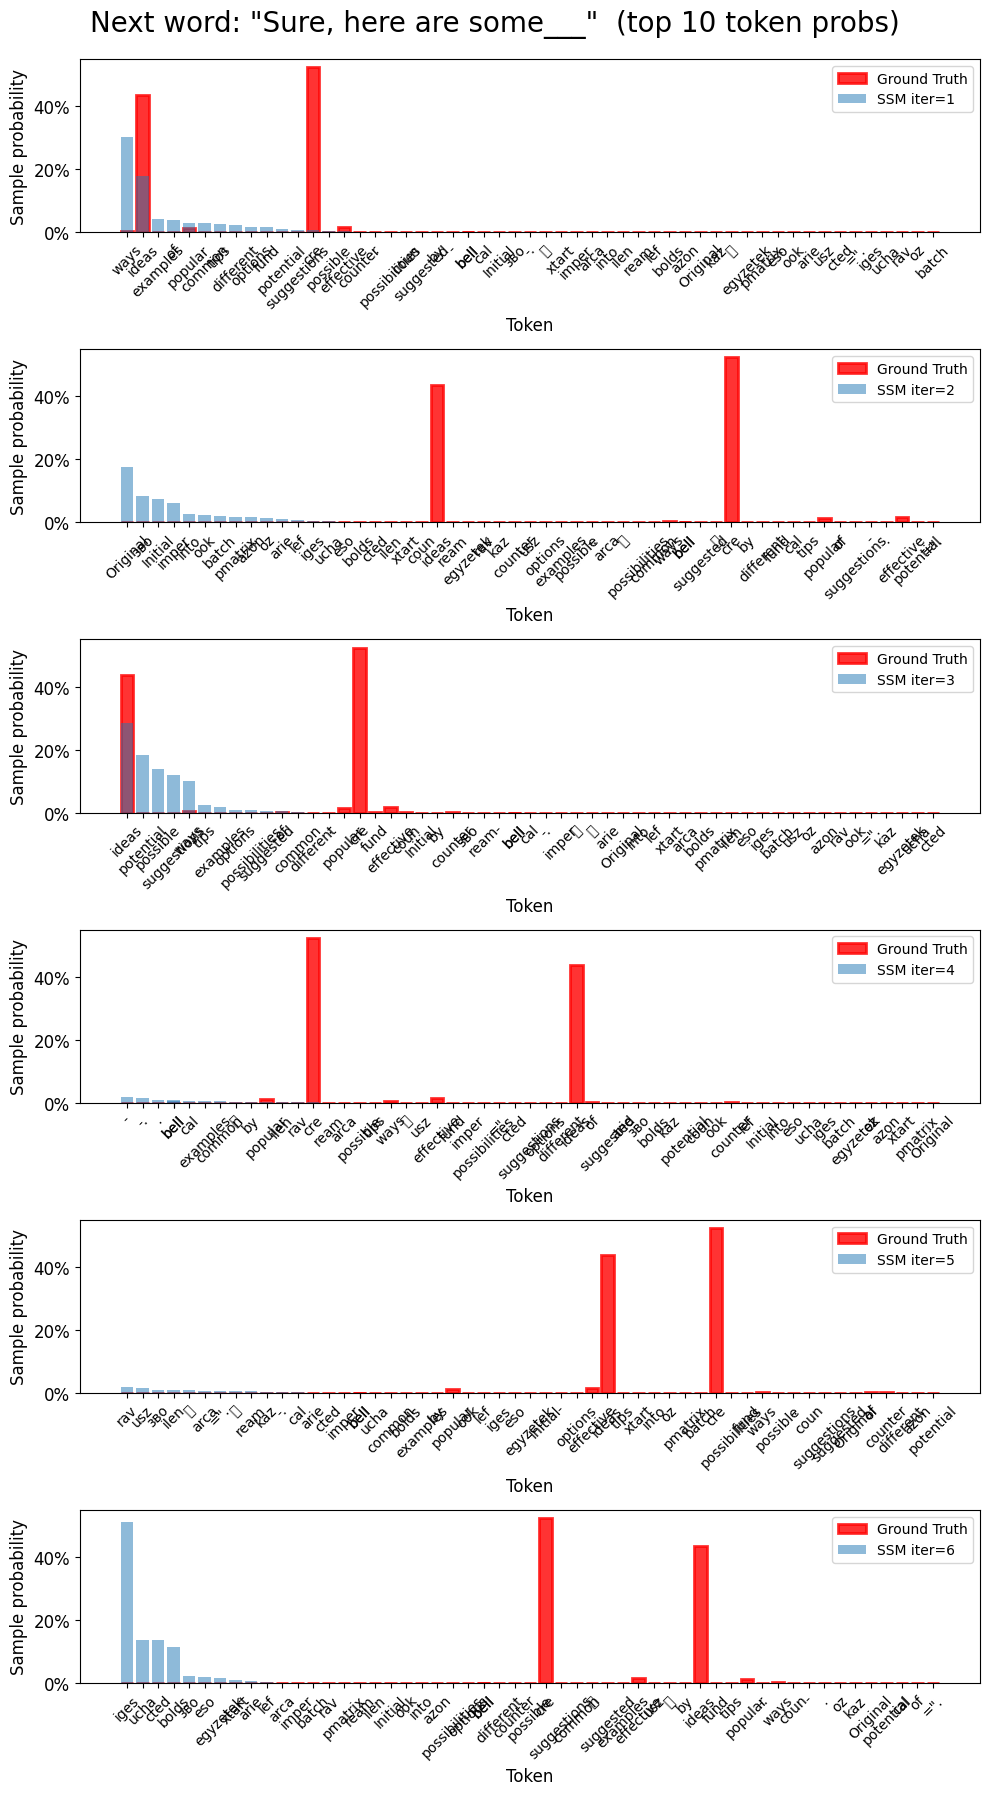

In [10]:
data_ind = 0
ind = 6 - 1
llm_logits = return_json['llm']['logits'][data_ind][ind]
ssm_logits = return_json['ssm']['logits'][data_ind][ind]
llm_output_ids = torch.cat((return_json['llm']["output_ids"][data_ind]), dim=-1)[:, :ind]


# get the union top-k distribution of ground truth and ssm
topk = 10
ground_truth_logits, union_topk_logits, union_topk_tokens = get_union_topk_distribution(llm_logits, ssm_logits, topk)

# get the prefix
prefix = tokenizer.batch_decode(llm_output_ids, skip_special_tokens=True)[0]
max_len = round(len(union_topk_tokens)*2)
if len(prefix) > max_len:
    prefix = '...' + prefix[-max_len:]

# plot the distribution
title = f'Next word: "{prefix}___"  (top {topk} token probs)'
plot_distributions(ground_truth_logits, union_topk_logits, union_topk_tokens, ind, title=title, sort_by_gt=False)

In [11]:
len(return_json['llm']['logits'])

20

## Test SSM sampling distortion against LLM

In [12]:
# device = "auto"
# dtype = torch.float16
# llm_path = "meta-llama/Llama-2-7b-chat-hf"
# dataset_dir = "Aeala/ShareGPT_Vicuna_unfiltered"
# ssm_path = "/home/nctu/checkpoints/eagle/l1-kl_1.0-0.1/model_20"
# sd_method = "sequoia"

# # load tokenizer
# tokenizer = AutoTokenizer.from_pretrained(llm_path, use_fast=False)

# # load LLM
# llm = AutoModelForCausalLM.from_pretrained(
#     llm_path, 
#     torch_dtype=dtype,
#     low_cpu_mem_usage=True,
#     device_map=device,
# )

# # SSM_Sequoia, SSM_Eagle
# ssm = SSM_Eagle.from_pretrained(
# # ssm = SSM_Sequoia.from_pretrained(
#     ssm_path, 
#     config=draft_config,
#     torch_dtype=dtype,
# ).to(llm.model.layers[-1].self_attn.q_proj.weight.device)

## Learn optimal temperature

https://github.com/gpleiss/temperature_scaling/blob/master/temperature_scaling.py

In [13]:
import torch
from torch import nn, optim
from torch.nn import functional as F

def calc_tvd_loss(s_logits, t_logits):
    with torch.no_grad():
        t_logits = F.softmax(t_logits, dim=-1)
    s_logits = F.softmax(s_logits, dim=-1)
    
    loss = F.l1_loss(s_logits, t_logits, reduction='mean')
    return loss

In [14]:
def set_temperature(model, valid_loader):
        # First: collect all the logits and labels for the validation set
        s_logits_list = []
        t_logits_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = model(input)
                s_logits_list.append(logits)
                t_logits_list.append(label)
            s_logits = torch.cat(s_logits_list).cuda()
            t_logits = torch.cat(t_logits_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        with torch.no_grad():
            before_temperature_tvd = calc_tvd_loss(s_logits, t_logits).item()
            print(f'Before temperature - TVD: {before_temperature_tvd:.4f}')

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([model.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = calc_tvd_loss(s_logits/model.temperature, t_logits)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE before temperature scaling
        with torch.no_grad():
            after_temperature_tvd = calc_tvd_loss(s_logits, t_logits).item()
            print(f'Optimal temperature: {model.temperature.item():.3f}')
            print(f'After temperature - TVD: {after_temperature_tvd:.4f}')

        return model